In [1]:
import os
os.chdir('..')
os.getcwd()

'/home/dema/PycharmProjects/lifelong_rl/VBLRL_rl_exam'

In [2]:
from metaworld.envs import (ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE)

from buffers import MultiEnvReplayBuffer
from bnn import BNN
from cem_optimizer_v2 import CEM_opt
from planner_module_v4 import Planner
from lion_opt import Lion

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import torchbnn as bnn
import torch
import tqdm
import json
import random

In [3]:
# the selected env for the test can get the maximum reward in a planning setting with horizon = 40
# id: 25
env = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE['reach-wall-v2-goal-observable']()
_ = env.reset()

/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
CAPACITY_BUFFER = 2_000
CAPACITY_BUFFER_TEST = 300
HORIZON = 30

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
buffer = MultiEnvReplayBuffer(CAPACITY_BUFFER)
buffer_test = MultiEnvReplayBuffer(CAPACITY_BUFFER_TEST)

#ps use only env 25 reach-wall-v2-goal-observable

# fill real buff
for ep in range(60): 
    s = env.reset()
    for h in range(HORIZON):
        a = env.action_space.sample()
        s_prime, rew, done, info = env.step(a)
        buffer.add(s, a, rew, s_prime, done, env_id=25)

# fill test buff
for ep in range(30): 
    s = env.reset()
    for h in range(20):
        a = env.action_space.sample()
        s_prime, rew, done, info = env.step(a)
        buffer_test.add(s, a, rew, s_prime, done, env_id=25)

In [6]:
buffer.elem_for_buffer, buffer_test.elem_for_buffer


(defaultdict(<function buffers.MultiEnvReplayBuffer.__init__.<locals>.<lambda>()>,
             {25: 1800}),
 defaultdict(<function buffers.MultiEnvReplayBuffer.__init__.<locals>.<lambda>()>,
             {25: 300}))

In [7]:

def train_with_elbo(net, buffer, optimizer, mse_loss, kl_loss, env_key):
    """
   training loop
    """
    states, actions, rewards, next_states, dones = buffer.sample_env(env_key, batch_size=BATCH_SIZE)

    optimizer.zero_grad()
    x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
    y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
    y_pred = net(x)

    mse = mse_loss(y_pred, y_true)
    kl = kl_loss(net)
    loss = mse + KL_WEIGHT * kl
    loss.backward()
    optimizer.step()
    return mse.item(), kl.item(), loss.item()


def test_with_elbo(net, buffer, mse_loss, kl_loss, env_key):
    """
   test loop
    """
    states, actions, rewards, next_states, dones = buffer.sample_env(env_key, batch_size=BATCH_SIZE)

    with torch.no_grad():
        
        x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
        y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
        y_pred = net(x)

        mse = mse_loss(y_pred, y_true)
        kl = kl_loss(net)
        loss = mse + KL_WEIGHT * kl
    
    return mse.item(), kl.item(), loss.item()


In [8]:

LR = 1e-4
KL_WEIGHT = 0.0001
BATCH_SIZE = 256


dynamic = BNN(action_dim=4, obs_dim=39, reward_dim=1).to(DEVICE)
optim = Lion(dynamic.parameters(), lr=LR)
counter_train = 0

kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(DEVICE)
mse_loss = torch.nn.MSELoss().to(DEVICE)

In [9]:
mse_history = []
kl_history = []
loss_tot_history = []

mse_history_test = []
kl_history_test = []
loss_tot_history_test = []

In [10]:

epochs = 7_000
counter_train += epochs



for ep in tqdm.tqdm(range(epochs)):
    
    mse, kl, loss = train_with_elbo(
        dynamic,
        buffer,
        optim,
        mse_loss,
        kl_loss, 
        env_key=25
    )
    
    mse_test, kl_test, loss_test = test_with_elbo(
        dynamic,
        buffer,
        mse_loss,
        kl_loss, 
        env_key=25
    )
    
    mse_history.append(mse)
    kl_history.append(kl)
    loss_tot_history.append(loss)
    
    mse_history_test.append(mse_test)
    kl_history_test.append(kl_test)
    loss_tot_history_test.append(loss_test)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:31<00:00, 221.51it/s]


'avg loss for last 50 ep: 0.1178524324297905, counter_train=7000'

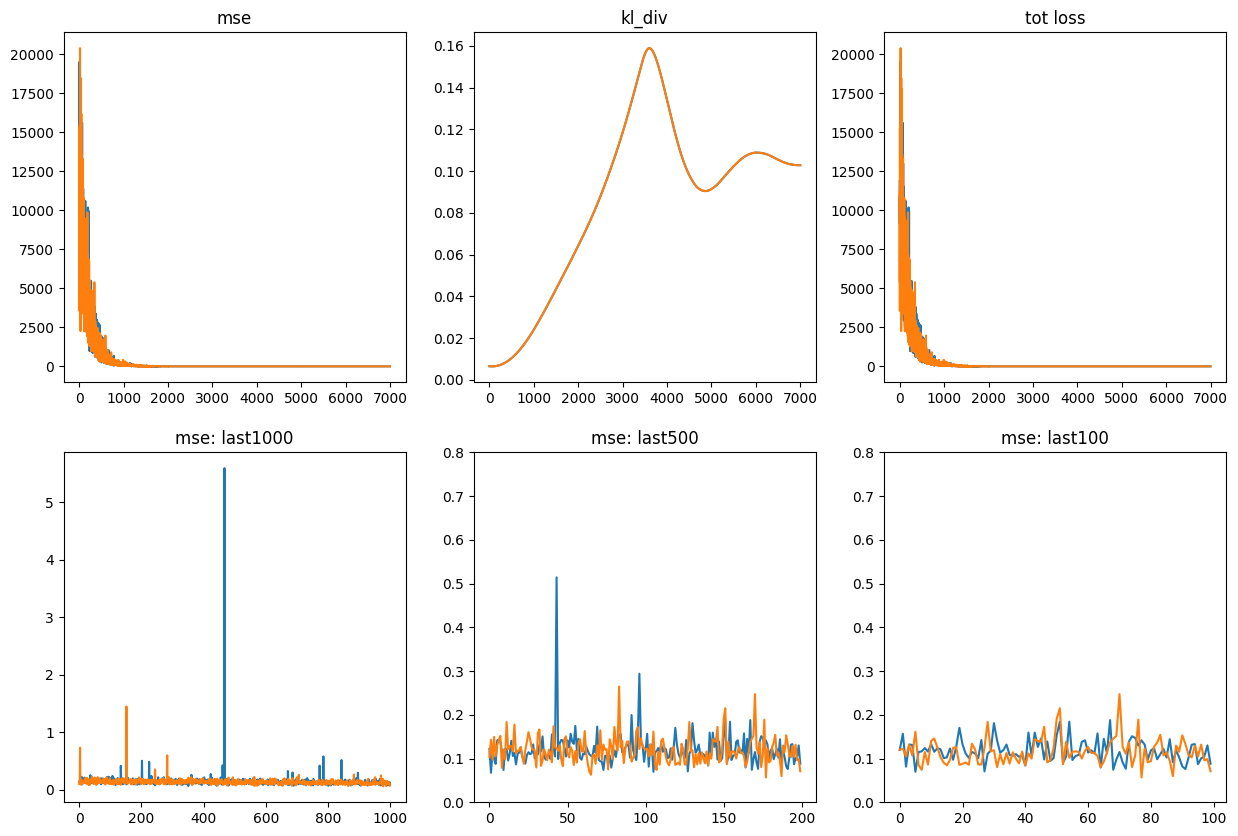

In [11]:
fig, axis = plt.subplots(2, 3, figsize=(15, 10))

axis[0, 0].set_title('mse')
axis[0, 0].plot(mse_history)
axis[0, 0].plot(mse_history_test)

axis[0, 1].set_title('kl_div')
axis[0, 1].plot(kl_history)
axis[0, 1].plot(kl_history_test)

axis[0, 2].set_title('tot loss')
axis[0, 2].plot(loss_tot_history)
axis[0, 2].plot(loss_tot_history_test)


# zoom
axis[1, 0].plot(mse_history[-1000:])
axis[1, 0].set_title('mse: last1000')
axis[1, 1].plot(mse_history[-200:])
axis[1, 1].set_title('mse: last500')
axis[1, 2].plot(mse_history[-100:])
axis[1, 2].set_title('mse: last100')



axis[1, 0].plot(mse_history_test[-1000:])
axis[1, 0].set_title('mse: last1000')
axis[1, 1].plot(mse_history_test[-200:])
axis[1, 1].set_title('mse: last500')
axis[1, 2].plot(mse_history_test[-100:])
axis[1, 2].set_title('mse: last100')
axis[1, 2].set_ylim(0, 0.8)
axis[1, 1].set_ylim(0, 0.8)


f'avg loss for last 50 ep: {sum(loss_tot_history[-50:])/50}, {counter_train=}'


In [73]:
torch.save(dynamic.state_dict(), f'model_stock/dynamic_small_evn_25_lr{LR}_{counter_train}EP.pth')

In [12]:
planner = Planner(
    dynamic, 
    num_sequence_action=100,
    num_particles=30,
    plan_horizon=HORIZON
)


In [13]:
history_summed_reward_for_ep = []
mse_plan_history = []
kl_plan_history = []
loss_plan_history = []

In [20]:
old_reward = 0
BACKPROP_STEP = 1

for ep in range(50):
    
    clear_output(wait=True)
    state = env.reset()
    
    reward_for_ep = []
    for step in range(30):  # horizon 
        action = planner.plan_step(state)

        s_prime, reward, done, info = env.step(action)
        buffer.add(state, action, reward, s_prime, done, 25)
        state = s_prime
        reward_for_ep.append(reward)

        avg_mse = []
        avg_kl = []
        avg_loss = []
        
        for _ in range(BACKPROP_STEP):
            counter_train += BACKPROP_STEP
            mse_score, kl_score, tot_loss_score = train_with_elbo(
                net=planner.dynamic,
                optimizer=optim,
                buffer=buffer,
                mse_loss=mse_loss,
                kl_loss=kl_loss, 
                env_key=25
            )

            avg_mse.append(mse_score)
            avg_kl.append(kl_score)
            avg_loss.append(tot_loss_score)
            
        avg_mse = sum(avg_mse)/len(avg_mse)
        avg_kl = sum(avg_kl)/len(avg_kl)
        avg_loss = sum(avg_loss)/len(avg_loss)
        
        
        mse_plan_history.append(avg_mse)
        kl_plan_history.append(avg_kl)
        loss_plan_history.append(avg_loss)
        
        print(f'{ep=}| {step=}, [mse, kl, tot]: {avg_mse:.4f} {avg_kl:.4f} {avg_loss:.4f}| reward {reward:.4f}')
    
    summed_reward_ep = sum(reward_for_ep)
    print(f'{summed_reward_ep=}, {old_reward=},{counter_train=}')
    old_reward = summed_reward_ep
    
    history_summed_reward_for_ep.append(summed_reward_ep)
    

ep=49| step=0, [mse, kl, tot]: 0.0309 0.0942 0.0310| reward 1.4822
ep=49| step=1, [mse, kl, tot]: 0.0212 0.0942 0.0212| reward 1.4840
ep=49| step=2, [mse, kl, tot]: 0.0235 0.0942 0.0235| reward 1.4856
ep=49| step=3, [mse, kl, tot]: 0.0285 0.0942 0.0285| reward 1.4816
ep=49| step=4, [mse, kl, tot]: 0.0243 0.0942 0.0243| reward 1.4729
ep=49| step=5, [mse, kl, tot]: 0.0197 0.0942 0.0197| reward 1.4596
ep=49| step=6, [mse, kl, tot]: 0.0361 0.0942 0.0361| reward 1.4475
ep=49| step=7, [mse, kl, tot]: 0.0260 0.0942 0.0260| reward 1.4401
ep=49| step=8, [mse, kl, tot]: 0.0220 0.0942 0.0220| reward 1.4296
ep=49| step=9, [mse, kl, tot]: 0.0224 0.0942 0.0224| reward 1.4123
ep=49| step=10, [mse, kl, tot]: 0.0128 0.0942 0.0128| reward 1.3923
ep=49| step=11, [mse, kl, tot]: 0.0173 0.0942 0.0174| reward 1.3769
ep=49| step=12, [mse, kl, tot]: 0.6539 0.0942 0.6539| reward 1.3634
ep=49| step=13, [mse, kl, tot]: 0.0206 0.0942 0.0206| reward 1.3472
ep=49| step=14, [mse, kl, tot]: 0.0260 0.0942 0.0260| rewa

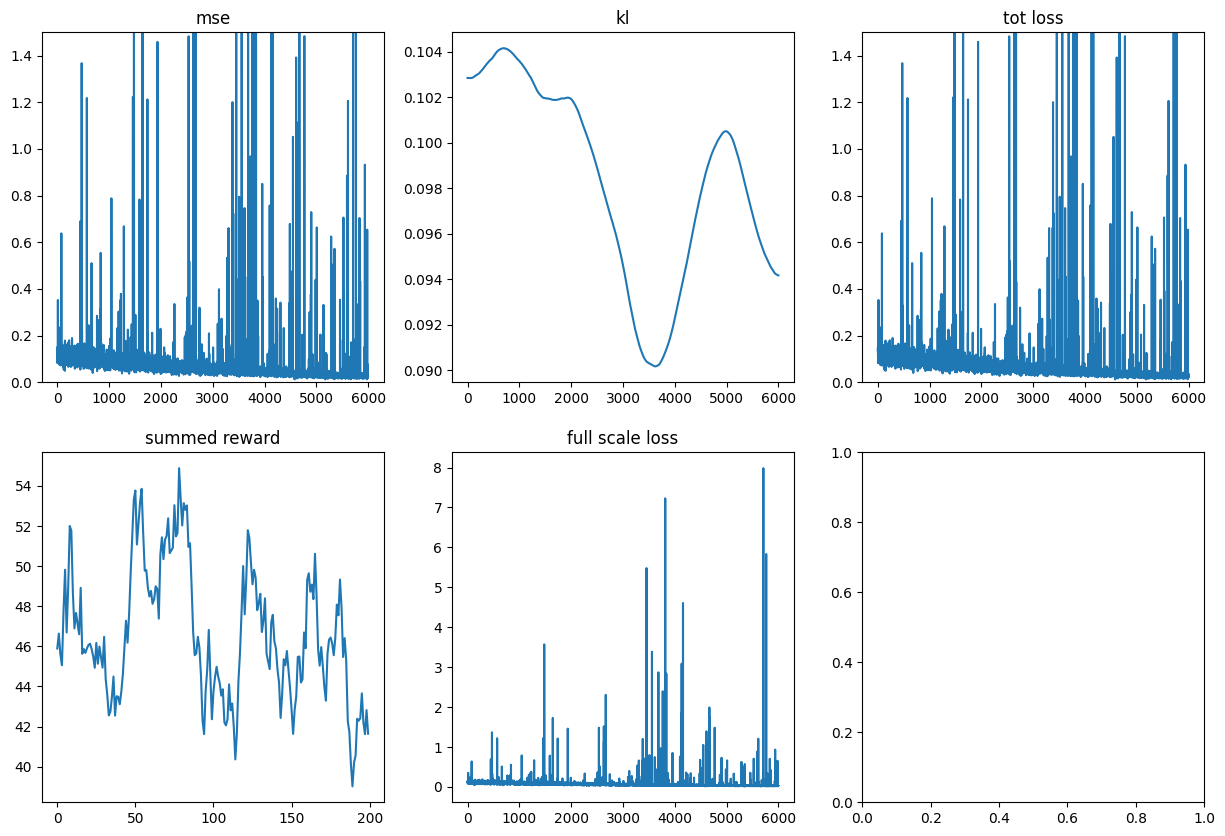

In [23]:
fig, axis = plt.subplots(2, 3, figsize=(15, 10))

axis[0, 0].set_ylim(0, 1.5)
axis[0, 2].set_ylim(0, 1.5)

axis[0, 0].plot(mse_plan_history)
axis[0, 0].set_title('mse')
axis[0, 1].plot(kl_plan_history)
axis[0, 1].set_title('kl')
axis[0, 2].plot(loss_plan_history)
axis[0, 2].set_title('tot loss')
# 
axis[1, 0].plot(history_summed_reward_for_ep)
axis[1, 0].set_title('summed reward')

axis[1, 1].set_title('full scale loss')
axis[1, 1].plot(mse_plan_history)



SECOND PART: cem buffer 

In [24]:
buffer = MultiEnvReplayBuffer(CAPACITY_BUFFER)
buffer_test = MultiEnvReplayBuffer(CAPACITY_BUFFER_TEST)

#ps use only env 25 reach-wall-v2-goal-observable

# fill real buff
buffer.read_buffers('buffer_stock/buffers_cem_solve/')

# fill test buff
for ep in range(30): 
    s = env.reset()
    for h in range(20):
        a = env.action_space.sample()
        s_prime, rew, done, info = env.step(a)
        buffer_test.add(s, a, rew, s_prime, done, env_id=25)

old buffer to load: name: ['buffer_env48.pkl', 'buffer_env22.pkl', 'buffer_env41.pkl', 'buffer_env43.pkl', 'buffer_env29.pkl', 'buffer_env09.pkl', 'buffer_env34.pkl', 'buffer_env40.pkl', 'buffer_env26.pkl', 'buffer_env01.pkl', 'buffer_env10.pkl', 'buffer_env13.pkl', 'buffer_env42.pkl', 'buffer_env49.pkl', 'buffer_env19.pkl', 'buffer_env45.pkl', 'buffer_env46.pkl', 'buffer_env35.pkl', 'buffer_env32.pkl', 'buffer_env50.pkl', 'buffer_env04.pkl', 'buffer_env15.pkl', 'buffer_env28.pkl', 'buffer_env20.pkl', 'buffer_env06.pkl', 'buffer_env18.pkl', 'buffer_env07.pkl', 'buffer_env33.pkl', 'buffer_env12.pkl', 'buffer_env16.pkl', 'buffer_env11.pkl', 'buffer_env23.pkl', 'buffer_env36.pkl', 'buffer_env05.pkl', 'buffer_env08.pkl', 'buffer_env30.pkl', 'buffer_env37.pkl', 'buffer_env14.pkl', 'buffer_env38.pkl', 'buffer_env24.pkl', 'buffer_env39.pkl', 'buffer_env17.pkl', 'buffer_env21.pkl', 'buffer_env44.pkl', 'buffer_env25.pkl', 'buffer_env31.pkl', 'buffer_env27.pkl', 'buffer_env03.pkl', 'buffer_env02

In [25]:

LR = 1e-4
KL_WEIGHT = 0.0001
BATCH_SIZE = 256


dynamic = BNN(action_dim=4, obs_dim=39, reward_dim=1).to(DEVICE)
optim = Lion(dynamic.parameters(), lr=LR)
counter_train = 0

kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(DEVICE)
mse_loss = torch.nn.MSELoss().to(DEVICE)

In [26]:
mse_history = []
kl_history = []
loss_tot_history = []

mse_history_test = []
kl_history_test = []
loss_tot_history_test = []

In [30]:

epochs = 7_000
counter_train += epochs



for ep in tqdm.tqdm(range(epochs)):
    
    mse, kl, loss = train_with_elbo(
        dynamic,
        buffer,
        optim,
        mse_loss,
        kl_loss, 
        env_key=25
    )
    
    mse_test, kl_test, loss_test = test_with_elbo(
        dynamic,
        buffer,
        mse_loss,
        kl_loss, 
        env_key=25
    )
    
    mse_history.append(mse)
    kl_history.append(kl)
    loss_tot_history.append(loss)
    
    mse_history_test.append(mse_test)
    kl_history_test.append(kl_test)
    loss_tot_history_test.append(loss_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:31<00:00, 221.72it/s]


'avg loss for last 50 ep: 0.46442925453186035, counter_train=14000'

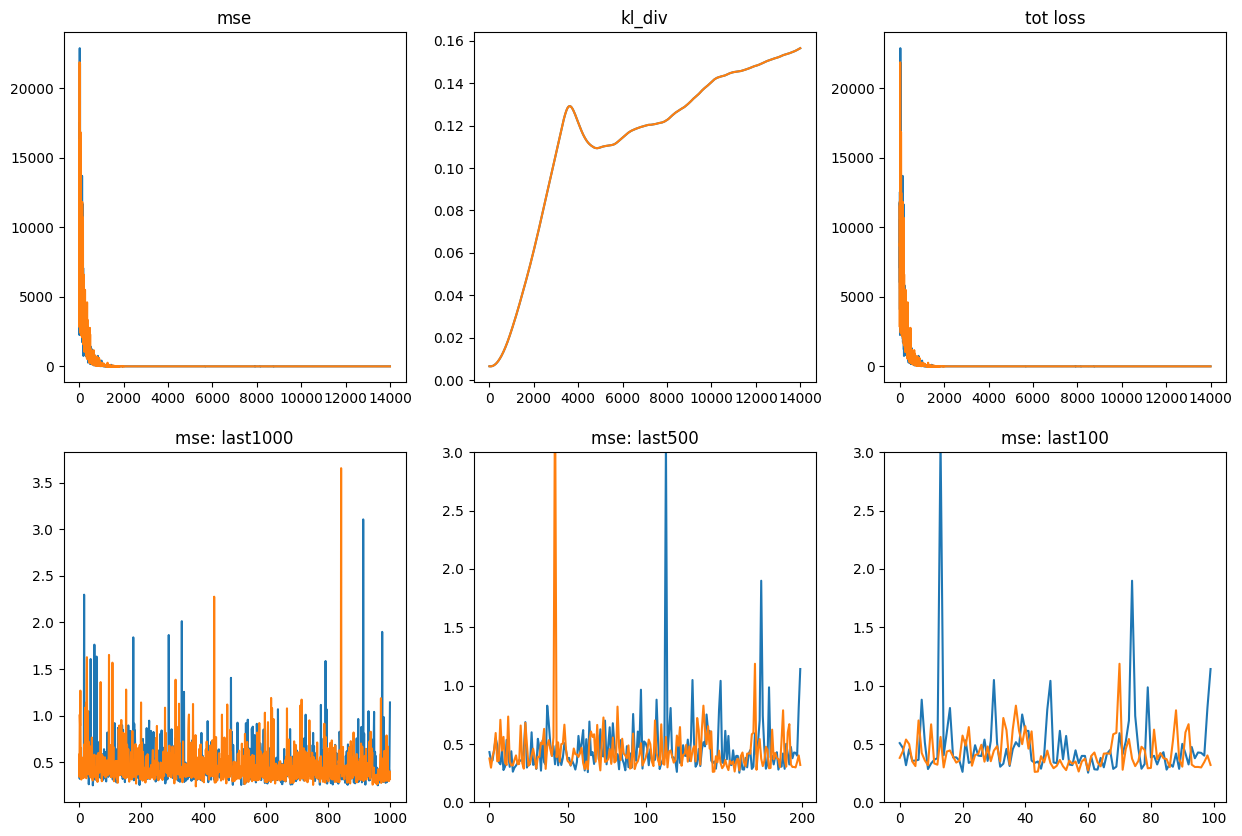

In [31]:
fig, axis = plt.subplots(2, 3, figsize=(15, 10))

axis[0, 0].set_title('mse')
axis[0, 0].plot(mse_history)
axis[0, 0].plot(mse_history_test)

axis[0, 1].set_title('kl_div')
axis[0, 1].plot(kl_history)
axis[0, 1].plot(kl_history_test)

axis[0, 2].set_title('tot loss')
axis[0, 2].plot(loss_tot_history)
axis[0, 2].plot(loss_tot_history_test)


# zoom
axis[1, 0].plot(mse_history[-1000:])
axis[1, 0].set_title('mse: last1000')
axis[1, 1].plot(mse_history[-200:])
axis[1, 1].set_title('mse: last500')
axis[1, 2].plot(mse_history[-100:])
axis[1, 2].set_title('mse: last100')



axis[1, 0].plot(mse_history_test[-1000:])
axis[1, 0].set_title('mse: last1000')
axis[1, 1].plot(mse_history_test[-200:])
axis[1, 1].set_title('mse: last500')
axis[1, 2].plot(mse_history_test[-100:])
axis[1, 2].set_title('mse: last100')
axis[1, 2].set_ylim(0, 3)
axis[1, 1].set_ylim(0, 3)


f'avg loss for last 50 ep: {sum(loss_tot_history[-50:])/50}, {counter_train=}'

In [32]:
planner = Planner(
    dynamic, 
    num_sequence_action=100,
    num_particles=30,
    plan_horizon=HORIZON
)


In [33]:
history_summed_reward_for_ep = []
mse_plan_history = []
kl_plan_history = []
loss_plan_history = []

In [38]:
old_reward = 0
BACKPROP_STEP = 1

for ep in range(50):
    
    clear_output(wait=True)
    state = env.reset()
    
    reward_for_ep = []
    for step in range(30):  # horizon 
        action = planner.plan_step(state)

        s_prime, reward, done, info = env.step(action)
        buffer.add(state, action, reward, s_prime, done, 25)
        state = s_prime
        reward_for_ep.append(reward)

        avg_mse = []
        avg_kl = []
        avg_loss = []
        
        counter_train += BACKPROP_STEP
        mse_score, kl_score, tot_loss_score = train_with_elbo(
            net=planner.dynamic,
            optimizer=optim,
            buffer=buffer,
            mse_loss=mse_loss,
            kl_loss=kl_loss, 
            env_key=25
        )
        
                

        avg_mse.append(mse_score)
        avg_kl.append(kl_score)
        avg_loss.append(tot_loss_score)
            
        avg_mse = sum(avg_mse)/len(avg_mse)
        avg_kl = sum(avg_kl)/len(avg_kl)
        avg_loss = sum(avg_loss)/len(avg_loss)
        
        
        mse_plan_history.append(avg_mse)
        kl_plan_history.append(avg_kl)
        loss_plan_history.append(avg_loss)
        
        print(f'{ep=}| {step=}, [mse, kl, tot]: {avg_mse:.4f} {avg_kl:.4f} {avg_loss:.4f}| reward {reward:.4f}')
    
    summed_reward_ep = sum(reward_for_ep)
    print(f'{summed_reward_ep=}, {old_reward=},{counter_train=}')
    old_reward = summed_reward_ep
    
    history_summed_reward_for_ep.append(summed_reward_ep)
    

ep=49| step=0, [mse, kl, tot]: 0.0105 0.1550 0.0105| reward 1.4833
ep=49| step=1, [mse, kl, tot]: 0.0054 0.1550 0.0054| reward 1.4879
ep=49| step=2, [mse, kl, tot]: 0.0090 0.1550 0.0090| reward 1.4950
ep=49| step=3, [mse, kl, tot]: 0.0096 0.1550 0.0096| reward 1.5004
ep=49| step=4, [mse, kl, tot]: 0.0070 0.1549 0.0070| reward 1.5017
ep=49| step=5, [mse, kl, tot]: 0.0055 0.1549 0.0055| reward 1.4975
ep=49| step=6, [mse, kl, tot]: 0.0110 0.1549 0.0110| reward 1.4907
ep=49| step=7, [mse, kl, tot]: 0.0127 0.1549 0.0127| reward 1.4883
ep=49| step=8, [mse, kl, tot]: 0.0116 0.1549 0.0116| reward 1.4964
ep=49| step=9, [mse, kl, tot]: 0.0076 0.1549 0.0076| reward 1.5163
ep=49| step=10, [mse, kl, tot]: 0.1384 0.1548 0.1384| reward 1.5406
ep=49| step=11, [mse, kl, tot]: 0.0073 0.1548 0.0073| reward 1.5644
ep=49| step=12, [mse, kl, tot]: 0.0087 0.1548 0.0087| reward 1.5860
ep=49| step=13, [mse, kl, tot]: 0.0092 0.1548 0.0093| reward 1.6015
ep=49| step=14, [mse, kl, tot]: 0.0083 0.1548 0.0084| rewa

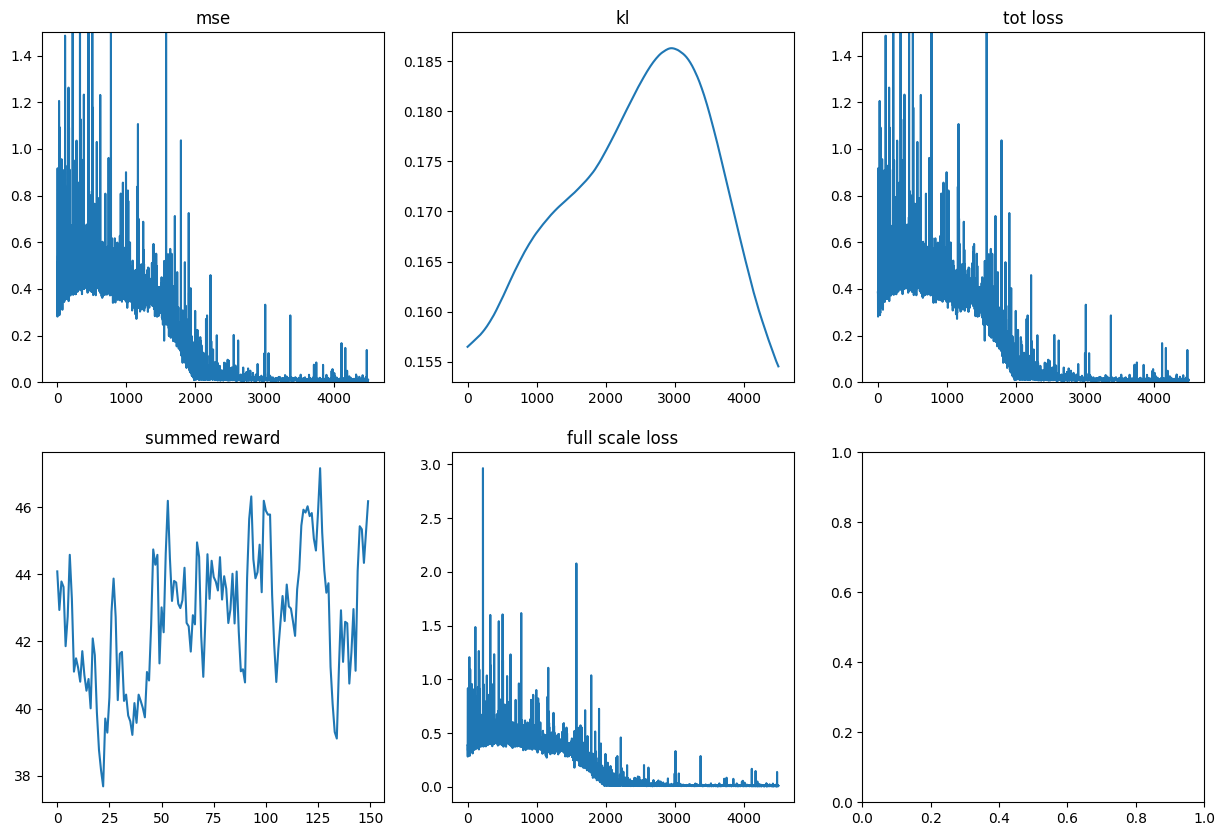

In [39]:
fig, axis = plt.subplots(2, 3, figsize=(15, 10))

axis[0, 0].set_ylim(0, 1.5)
axis[0, 2].set_ylim(0, 1.5)

axis[0, 0].plot(mse_plan_history)
axis[0, 0].set_title('mse')
axis[0, 1].plot(kl_plan_history)
axis[0, 1].set_title('kl')
axis[0, 2].plot(loss_plan_history)
axis[0, 2].set_title('tot loss')
# 
axis[1, 0].plot(history_summed_reward_for_ep)
axis[1, 0].set_title('summed reward')

axis[1, 1].set_title('full scale loss')
axis[1, 1].plot(mse_plan_history)